In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from PIL import Image  # Import PIL to resize images
import shutil
import seaborn as sns

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
if torch.cuda.is_available():
    device = torch.device("cuda")  # Set device to GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
S_img_list = np.load('SVD_Real_Images/S_img_list.npy')
S_adv_list=np.load('SVD_ADV_Images/S_adv_list.npy')

## Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SVDModel(nn.Module):
    def __init__(self,input_size,output_size):
        super(SVDModel, self).__init__()
        #layers
        # self.fc1 = nn.Linear(input_size,512)
        # self.fc2 = nn.Linear(512,256)
        # self.fc3 = nn.Linear(256,output_size)
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),  
            nn.ReLU(),  
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,output_size)
        )
    def forward(self, x):
        # Define the forward pass
        # x = F.relu(self.fc1(x))  # Apply ReLU after first layer
        # x = F.relu(self.fc2(x))  # Apply ReLU after second layer
        # x = self.fc3(x)          # Final layer, no activation (linear output)
        x = self.model(x)
        return x
        

In [4]:
sub_model = SVDModel(174,174)

In [5]:
S_list = torch.tensor(S_img_list).float()
S_label_list = torch.tensor(S_adv_list).float()

In [6]:
S_list.shape

torch.Size([800, 224])

In [7]:
S_list = S_list[:,50:]
S_label = S_label_list[:,50:]

In [8]:
S_list.shape

torch.Size([800, 174])

In [9]:
S_list.shape,S_label.shape

(torch.Size([800, 174]), torch.Size([800, 174]))

In [10]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
# train_dataset = TensorDataset(X_train,y_train)
# test_dataset = TensorDataset(X_test,y_test)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
S_list_train,S_list_test,S_label_train,S_label_test = train_test_split(S_list,S_label,test_size=0.2,random_state=0)
train_dataset = TensorDataset(S_list_train,S_label_train)
test_dataset = TensorDataset(S_list_test,S_label_test)
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [11]:
criterion = nn.L1Loss()
optimizer = optim.Adam(sub_model.parameters(),lr=0.00001)

In [12]:
epochs = 5000
train_LOSS = []
test_LOSS = []
train_MSE = []
test_MSE = []
train_R2 = []
test_R2 = []
sub_model.to(device)
for epoch in range(epochs):
    sub_model.train()
    train_loss = 0
    mse_loss = 0
    all_targets = []
    all_preds = []
    for inputs,target in train_dataloader:
        # print(input.squeeze(0))
        inputs,target = inputs.to(device),target.to(device)
        optimizer.zero_grad()
        output = sub_model(inputs)
        # print(output)
        # print(target)
        loss = criterion(output,target)
        train_loss+=loss.item()* inputs.size(0)
        mse_loss += F.mse_loss(output, target, reduction='sum').item()
        all_targets.append(target.cpu().detach().numpy())  # Store actual values
        all_preds.append(output.cpu().detach().numpy())  # Store predictions
        # print(loss)
        loss.backward()        
        optimizer.step()
    # Convert lists to numpy arrays for R² computation
    train_all_targets = np.concatenate(all_targets, axis=0)
    train_all_preds = np.concatenate(all_preds, axis=0)
    if epoch%1==0:
        train_LOSS.append(train_loss/len(train_dataset))
        train_MSE.append(mse_loss/len(train_dataset))
        train_R2.append(r2_score(train_all_targets,train_all_preds))

    #Validation
    sub_model.eval()
    val_loss = 0.0
    test_mse_loss = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = sub_model(inputs)
            loss = criterion(outputs, labels)
            val_loss+=loss.item()* inputs.size(0)
            test_mse_loss += F.mse_loss(outputs, labels, reduction='sum').item()
            all_targets.append(labels.cpu().detach().numpy())  # Store actual values
            all_preds.append(outputs.cpu().detach().numpy())  # Store predictions
        all_targets = np.concatenate(all_targets, axis=0)
        all_preds = np.concatenate(all_preds, axis=0)
        test_LOSS.append(val_loss/len(test_dataset))
        test_MSE.append(test_mse_loss/len(test_dataset))
        test_R2.append(r2_score(all_targets, all_preds))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataset)}, Train MSE: {mse_loss/len(train_dataset)}, Train R²: {r2_score(train_all_targets, train_all_preds)}")
    print(f"\t\t Val Loss: {val_loss/len(test_dataset)},Val MSE: {test_mse_loss/len(test_dataset)}, Val R²: {r2_score(all_targets, all_preds)}")

Epoch 1/5000, Train Loss: 0.3664477072656155, Train MSE: 33.684698820114136, Train R²: -102.17278289794922
		 Val Loss: 0.3632429301738739,Val MSE: 33.32168731689453, Val R²: -86.42803192138672
Epoch 2/5000, Train Loss: 0.3651084750890732, Train MSE: 33.509098863601686, Train R²: -100.99418640136719
		 Val Loss: 0.3618864506483078,Val MSE: 33.14519710540772, Val R²: -85.4525375366211
Epoch 3/5000, Train Loss: 0.36370936036109924, Train MSE: 33.32639455795288, Train R²: -99.89183807373047
		 Val Loss: 0.36042667031288145,Val MSE: 32.95604991912842, Val R²: -84.59730529785156
Epoch 4/5000, Train Loss: 0.36214477345347407, Train MSE: 33.12306652069092, Train R²: -98.84325408935547
		 Val Loss: 0.3587247937917709,Val MSE: 32.73787784576416, Val R²: -83.6767578125
Epoch 5/5000, Train Loss: 0.3601499177515507, Train MSE: 32.8706075668335, Train R²: -97.53367614746094
		 Val Loss: 0.356212255358696,Val MSE: 32.42369747161865, Val R²: -82.74630737304688
Epoch 6/5000, Train Loss: 0.356656563282

In [13]:
train_LOSS = np.array(train_LOSS)
train_MAE = np.array(train_MSE)
train_R2 = np.array(train_R2)
test_LOSS = np.array(test_LOSS)
test_MAE = np.array(test_MSE)
test_R2 = np.array(test_R2)

In [14]:
len(train_LOSS),len(test_LOSS)

(5000, 5000)

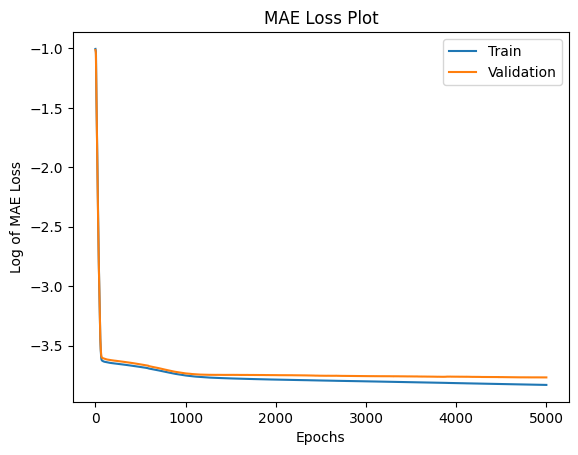

In [28]:
plt.plot(np.log(train_LOSS),label='Train')
plt.plot(np.log(test_LOSS),label='Validation')
plt.legend()
plt.title('MAE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Log of MAE Loss')
plt.savefig('MAE Plot.png')

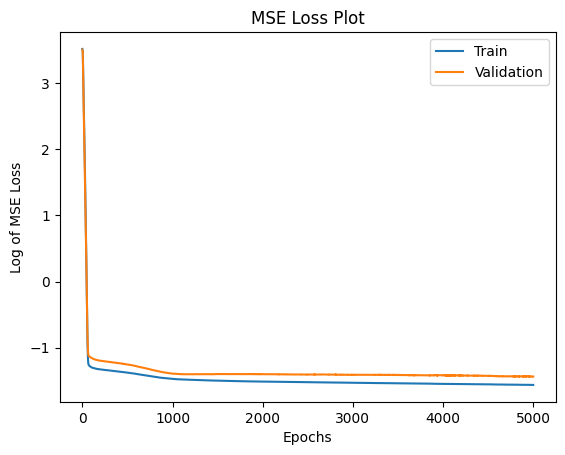

In [29]:
plt.plot(np.log(train_MSE),label='Train')
plt.plot(np.log(test_MSE),label='Validation')
plt.legend()
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Log of MSE Loss')
plt.savefig('MSE Plot.png')

C:\Users\david\AppData\Local\Temp\ipykernel_21776\4139747513.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(R2/R2.max()))


Text(0.5, 0, 'Epoch')

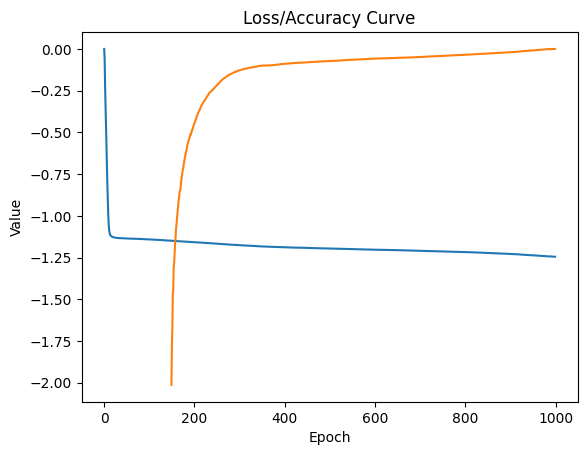

In [38]:
plt.plot(np.log10(LOSS/LOSS.max()))
plt.plot(np.log10(R2/R2.max()))
plt.title('Loss/Accuracy Curve')
plt.ylabel('Value')
plt.xlabel('Epoch')
# plt.savefig('Lossplot.png')

In [24]:
plt.plot(MAE/max(MAE))
plt.title('Error Plot')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.yticks([5,10,15,20,25,30,35,40,45,50,55,60,65],[5,10,15,20,25,30,35,40,45,50,55,60,65])
plt.savefig('Errorplot.png')

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [27]:
torch.save(sub_model,'sub_model.pth')

In [32]:
import torchvision.models as models

class VGG16Binary(nn.Module):
    def __init__(self):
        super(VGG16Binary, self).__init__()
        self.vgg16 = models.vgg16(weights=True)
        # Freeze all the layers in the VGG16 model
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a custom binary classifier
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2),  # Binary classification - 2 output classes
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.vgg16(x)
model = VGG16Binary()
model.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = torch.load("/kaggle/input/xray-model/xray.pth")
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]  
<ipython-input-32-5873fa06fc4b>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

VGG16Binary(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [ ]:
sub_model.eval()

In [14]:
out = sub_model(S_list[0])

In [16]:
out.shape

torch.Size([206])

In [18]:
S_atk = np.zeros(256)
S_atk[0:50] = S_img_list[0][0:50]
S_atk[50:] = out.detach().numpy()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

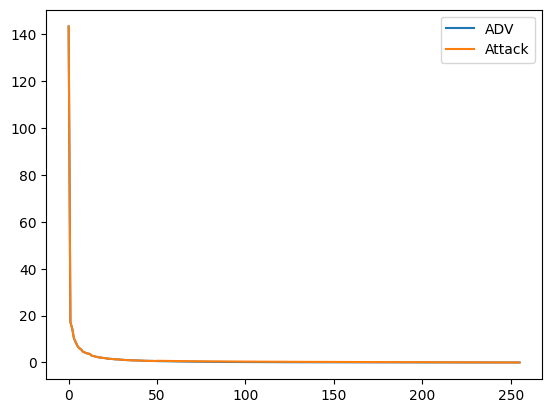

In [20]:
sns.lineplot(S_adv_list[0],label='ADV')
sns.lineplot(S_atk,label='Attack')
plt.legend()

In [26]:
def reconstruction(U,S,Vt):
    Sigma = np.zeros((256,256))# assuming image is 224x224
    np.fill_diagonal(Sigma, S)
    img = np.dot(U, np.dot(Sigma, Vt))
    # img = np.clip(img, 0, 1)
    # plt.imshow(img,cmap='gray')
    img = torch.tensor(img)
    img = img.unsqueeze(0)
    img = img.unsqueeze(0).float()
    return img

In [21]:
U_img_list = np.load('/kaggle/input/svd-values/U_img_list.npy')
V_img_list = np.load('/kaggle/input/svd-values/V_img_list.npy')
U_adv_list = np.load('/kaggle/input/svd-values/U_adv_list.npy')
V_adv_list = np.load('/kaggle/input/svd-values/V_adv_list.npy')

In [27]:
adv_img = reconstruction(U_img_list[0],S_atk,V_img_list[0])

In [28]:
img_name[0]

NameError: name 'img_name' is not defined

In [30]:
encoding = {'normal':0,'pneumonia':1}

In [33]:
out1 = model(adv_img.to(device))
pred1 = torch.max(out1.data,1)[1]
pred1

tensor([0], device='cuda:0')

In [38]:
out1

tensor([[-0.5174, -0.9065]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [35]:
real_img = reconstruction(U_img_list[0],S_img_list[0],V_img_list[0])

In [ ]:
weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(3, 1, 1)

In [ ]:
plt.imshow((real_img.squeeze(0)* weights).sum(dim=0),cmap='gray')

In [36]:
out = model(real_img.to(device))
pred = torch.max(out.data,1)[1]
pred

tensor([0], device='cuda:0')

In [37]:
out

tensor([[-0.5365, -0.8790]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [ ]:
plt.imshow((adv_img.squeeze(0)* weights).sum(dim=0),cmap='gray')

In [39]:
out1 = model(adv_img.to(device))
pred1 = torch.max(out1.data,1)[1]
pred1

tensor([0], device='cuda:0')

In [40]:
out1

tensor([[-0.5174, -0.9065]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [ ]:
S_atk

In [ ]:
S_try = S_atk.copy()

In [ ]:
S_try = S_try+(0.001)

In [ ]:
for i in range(220,224,1):
    S_try[i] = S_try[i] +(0.9)**(224-i) 

In [ ]:
# S_try

In [ ]:
try1 = reconstruction(U_img_list[0],S_try,Vt_img_list[0])

In [ ]:
plt.imshow((try1.squeeze(0)* weights).sum(dim=0),cmap='gray')

In [ ]:
out1 = model(try1.to(device))
pred1 = torch.max(out1.data,1)[1]
pred1

In [ ]:
out1

In [ ]:
out1

In [ ]:
ssim_score = ssim(real_img,try1,data_range=1.0)
ssim_score

In [ ]:
# def attack(model,img): # img must be in RGB
#     img_out = model(img.to(device))
#     label = torch.max(img_out,1)[1] # label to calculate loss
#     # Converting to gray scale for SVD
#     weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(3, 1, 1) # to convert RGB to Gray-Scale
#     img_gray = (img.squeeze(0) * weights).sum(dim=0)
#     # SVD on img
#     U_img, S_img, Vt_img = torch.linalg.svd(img_gray)
    
#     # Pertubation on Singular Values
#     S_adv = initial_S_adv(S_img)
#     S_adv_param = torch.tensor(S_adv,requires_grad=True)
    
#     adv_pred = label
#     loop = 1
#     optimz = optim.Adam([S_adv_param],lr=0.1)
#     lossfunc = nn.CrossEntropyLoss()
#     while adv_pred.item() == label.item():
#         print('Loop: ',loop)
#         adv_img = reconstruction(U_img,S_adv,Vt_img)
#         adv_img = adv_img.to(device)
#         output = model(adv_img)
#         adv_pred = torch.max(output.data,1)[1]
    
#         #Criterion
        
#         ssim_score = ssim(img.to(device),adv_img,data_range=1.0)  # SSIM

    
#         #loss
#         alpha = 0.01
#         loss = lossfunc(output,label) + (alpha*ssim_score)
    
#         #Optimization
#         optimz.zero_grad()
#         (-loss).backward()
#         optimz.step() 
#         # S_adv = S_adv_param.squeeze(0).to('cpu')
#         # S_adv = S_adv.detach()
#         loop+=1

#         if loop > 1500:
#             print("Reached maximum iterations without flipping the prediction.")
#             return None
        
#     success+=1
#     return (U_img, S_adv_param.detach().cpu().numpy(), Vt_img)
    
    

In [ ]:
# sub_model.eval()
# pred_S_adv = []
# LOSS = []
# for input,target in dataloader:

#     output = sub_model(input)
#     loss = criterion(output,target)
#     LOSS.append(loss.item())
#     pred_S_adv.append(output.squeeze(0))
#     print('Loss: ',loss.item())

In [ ]:
# plt.plot(LOSS)

In [ ]:
# len(pred_S_adv)

In [ ]:
# avg_change.shape

In [ ]:
# success = 0
# for i in range(len(dataset)):
#     real_img = reconstruction(U_img_list[i],S_img_list[i],Vt_img_list[i])
#     adv_img = reconstruction(U_img_list[i],pred_S_adv[i].detach().numpy(),Vt_img_list[i])

#     out1 = model(real_img.to(device))
#     pred1 = torch.max(out1.data,1)[1].item()
#     out2 = model(adv_img.to(device))
#     pred2 = torch.max(out2.data,1)[1].item()

#     if pred1 != pred2:
#         success+=1  
#     else:
#         U,S,Vt = attack(model,real_img)
        

In [ ]:
# success

In [ ]:
################# My Code #############################
def optimized(pred1,pred2,img,adv):
    cond1=1 if pred1 != pred2 else 0
    print(cond1)
    score = ssim(img.numpy(),adv.numpy(),data_range=adv.max().item() - adv.min().item()).item()
    print(score)
    # net=cond1+score
    return cond1==1

def shrink(img, tau,n,a,p=.1):
    V = np.copy(img).reshape(img.size)
    # for j in range(1):
    for i in range(V.size-n,V.size):
        V[i] = V[i] - (a * tau) / ((1 + np.abs(V[i])) ** p)
    return V.reshape(img.shape)

def svm_attack(img,model,tau,pred1):
    for n in range(1,201):
        a=0.4
        tau=0.095
        pred2=pred1
        adv=img
        while not optimized(pred1,pred2,img,adv):
            print('n - ',n)
            U, s, V = np.linalg.svd(img, full_matrices=False)
            # print(U.shape,s.shape,V.shape)
            adv= np.matmul(U, np.matmul(np.diag(shrink(s, tau,n,a)),V))
            adv=torch.from_numpy(adv).unsqueeze(0)
    
            adv_rgb = adv.repeat(3,1,1).unsqueeze(0)
            pred2=model(adv_rgb.to(device))
            print('Class Prob:', pred2)
            pred2=np.argmax(pred2.to('cpu').detach().numpy())
            print("Pred2 - ",pred2)
            print('--------------------------------------------------------------------------------------------')
            print('--------------------------------------------------------------------------------------------')
            sim = ssim(img.numpy(),adv.squeeze().numpy(),data_range=adv.max().item() - adv.min().item()).item()
            adv=adv.squeeze(0).squeeze(0)
            if sim<0.85:
                print('Not Optimized')
                break
            a*=1.01
            if optimized(pred1,pred2,img,adv):
                return adv
    
    return adv


In [ ]:
weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(3, 1, 1)

In [ ]:
image=Image.open('train/benign/benign (10).png').convert('RGB')
image_a=transform(image)
plt.imshow((image_a.squeeze(0).squeeze(0)* weights).sum(dim=0),cmap='gray')
plt.show()
image_a =image_a.unsqueeze(0)
output =model(image_a.to(device))
pred_label=torch.argmax(output)
print("Predicted Class:", pred_label.item())
############ SVM Attack############################
image_b = (image_a.squeeze(0)* weights).sum(dim=0)
adv=svm_attack(image_b,model,0.65,pred_label)
adv_rgb = adv.repeat(3,1,1).unsqueeze(0)
adv_output =model(adv_rgb.to(device))
adv_label=torch.argmax(adv_output)

print("Predicted Class:", adv_label.item())

plt.imshow(adv,cmap='gray')
plt.show()

In [ ]:
adv_output =model(adv_rgb.to(device))
adv_label=torch.argmax(adv_output)
print("Predicted Class:", decoding[adv_label.item()])

In [ ]:
########################## To plot original and adversarial images#####################
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_b,cmap='gray')


plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
# Convert tensor to numpy and then display
plt.imshow(adv,cmap='gray')
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
# Convert PyTorch tensors to NumPy arrays before passing to ssim
# Convert PyTorch tensors to NumPy arrays before passing to ssim
score, diff = ssim(image_b.squeeze().cpu().detach().numpy(),
                   adv.cpu().detach().numpy(),
                   full=True,
                   data_range=adv.max().item() - adv.min().item()) # Add data_range parameter
print("SSIM:",score)

In [ ]:
adv.shape

In [ ]:
image=Image.open('train/benign/benign (10).png').convert('RGB')
image_a=transform(image)
image_b = (image_a.squeeze(0)* weights).sum(dim=0)
image_b.shape

In [ ]:
U, s, V = np.linalg.svd(image_b, full_matrices=False)

In [ ]:
# sub_model.eval()
# s_adv = sub_model(torch.tensor(s))
# s_adv=s_adv.detach().numpy()

In [ ]:
# image_a= np.matmul(U, np.matmul(np.diag(s_adv),V))

In [ ]:
# image_a = torch.tensor(image_a).unsqueeze(0)

In [ ]:
# image_a = image_a.repeat(3,1,1)

In [ ]:
# image_a.shape

In [ ]:
# plt.imshow((image_a.squeeze(0).squeeze(0)* weights).sum(dim=0),cmap='gray')
# plt.show()
# image_a =image_a.unsqueeze(0)
# output =model(image_a.to(device))
# pred_label=torch.argmax(output)
# print("Predicted Class:", pred_label.item())
# ############ SVM Attack############################
# image_b = (image_a.squeeze(0)* weights).sum(dim=0)
# adv=svm_attack(image_b,model,0.65,pred_label)
# adv_output =model(adv.unsqueeze(0).unsqueeze(0).to(device))
# adv_label=torch.argmax(adv_output)
# print("Predicted Class:", adv_label.item())
# plt.imshow(adv,cmap='gray')
# plt.show()

In [ ]:
adv= np.matmul(U, np.matmul(np.diag(adv6),V))

In [ ]:
adv.shape

In [ ]:
adv = torch.tensor(adv).unsqueeze(0)
adv = adv.repeat(3,1,1)

In [ ]:
model.eval()

In [ ]:
out = model(adv.unsqueeze(0).float().to(device))
pred = torch.max(out.data,1)[1]

In [ ]:
pred

In [ ]:
out

In [ ]:
((adv6-s)/s)*100